<a href="https://colab.research.google.com/github/MarineDelabaere/Projet_ML_UE_AAA/blob/main/ML_Project_UE_D_AAA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Utilisation du Machine Learning pour prédire les performances des étudiants en fonction de plusieurs caractéristiques***


**Ce projet de Machine Learning s'inscrit dans le cadre de l'UE D AAA (Algorithmes et Apprentissage automatique) proposée par l'école d'ingénieur IMT Atlantique basée à Nantes en France. Il est réalisé par Marine Delabaere, étudiante de cette école.**

***I)Téléchargement des données***

In [1]:
from google.colab import files
uploaded = files.upload()


Saving student-por.csv to student-por.csv


In [2]:
import pandas as pd
import io
student_performance= pd.read_csv(io.BytesIO(uploaded['student-por.csv']), sep=";")
target_name = "G3"
data = student_performance.drop(columns=target_name)
target = student_performance[target_name]

***II)Exploration des données***

Ce projet a pour ambition de développer un modèle de machine learning capable de prédire les résultats scolaires en cours de portugais d'étudiants portugais de deux établissements scolaires distincts : le lycée Gabriel Pereira et le lycée Mousinho da Silveira. Le dataset comporte 649 instances et 33 variables.
Les variables 0, 1, 3, 4, 5, 8, 9, 10, 11, 15, 16, 17, 18, 19, 20, 21 et 22 sont catégorielles. Elles représentent des catégories comme l'établissement scolaire, le sexe, la relation des parents (vivant ensemble ou séparément), le travail des parents, l'accès à Internet etc.
  Toutes les autres sont numériques (l'âge, la consommation d'alcool, le nombre d'absences etc).

  **La target est G3 c'est-à-dire la note (de 0 à 20) obtenu par l'élève en cours de portugais au troisième (et donc dernier) trimestre.**

  Il s'agit donc d'un cas d'apprentissage supervisé plus particulièrement d'un problème de **régression**.

Initialement, il y avait deux datasets : un concernant la performance en mathématiques et l'autre pour la performance en portugais. Ce dernier possédant un peu plus d'instances que le premier, j'ai choisi de l'étudier.

In [3]:
student_performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

Bonne nouvelle : on remarque que l'on n'a **aucune valeur manquante**. Cela va nous épargner du travail dans la partie pré-traitement des données.

Quelques instances du dataset :

In [4]:
student_performance.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


Quelques statistiques basiques sur les données :

In [5]:
student_performance.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,16.744222,2.514638,2.306626,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.399076,11.570108,11.906009
std,1.218138,1.134552,1.099931,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,2.745265,2.913639,3.230656
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


***III) Visualisation des données***

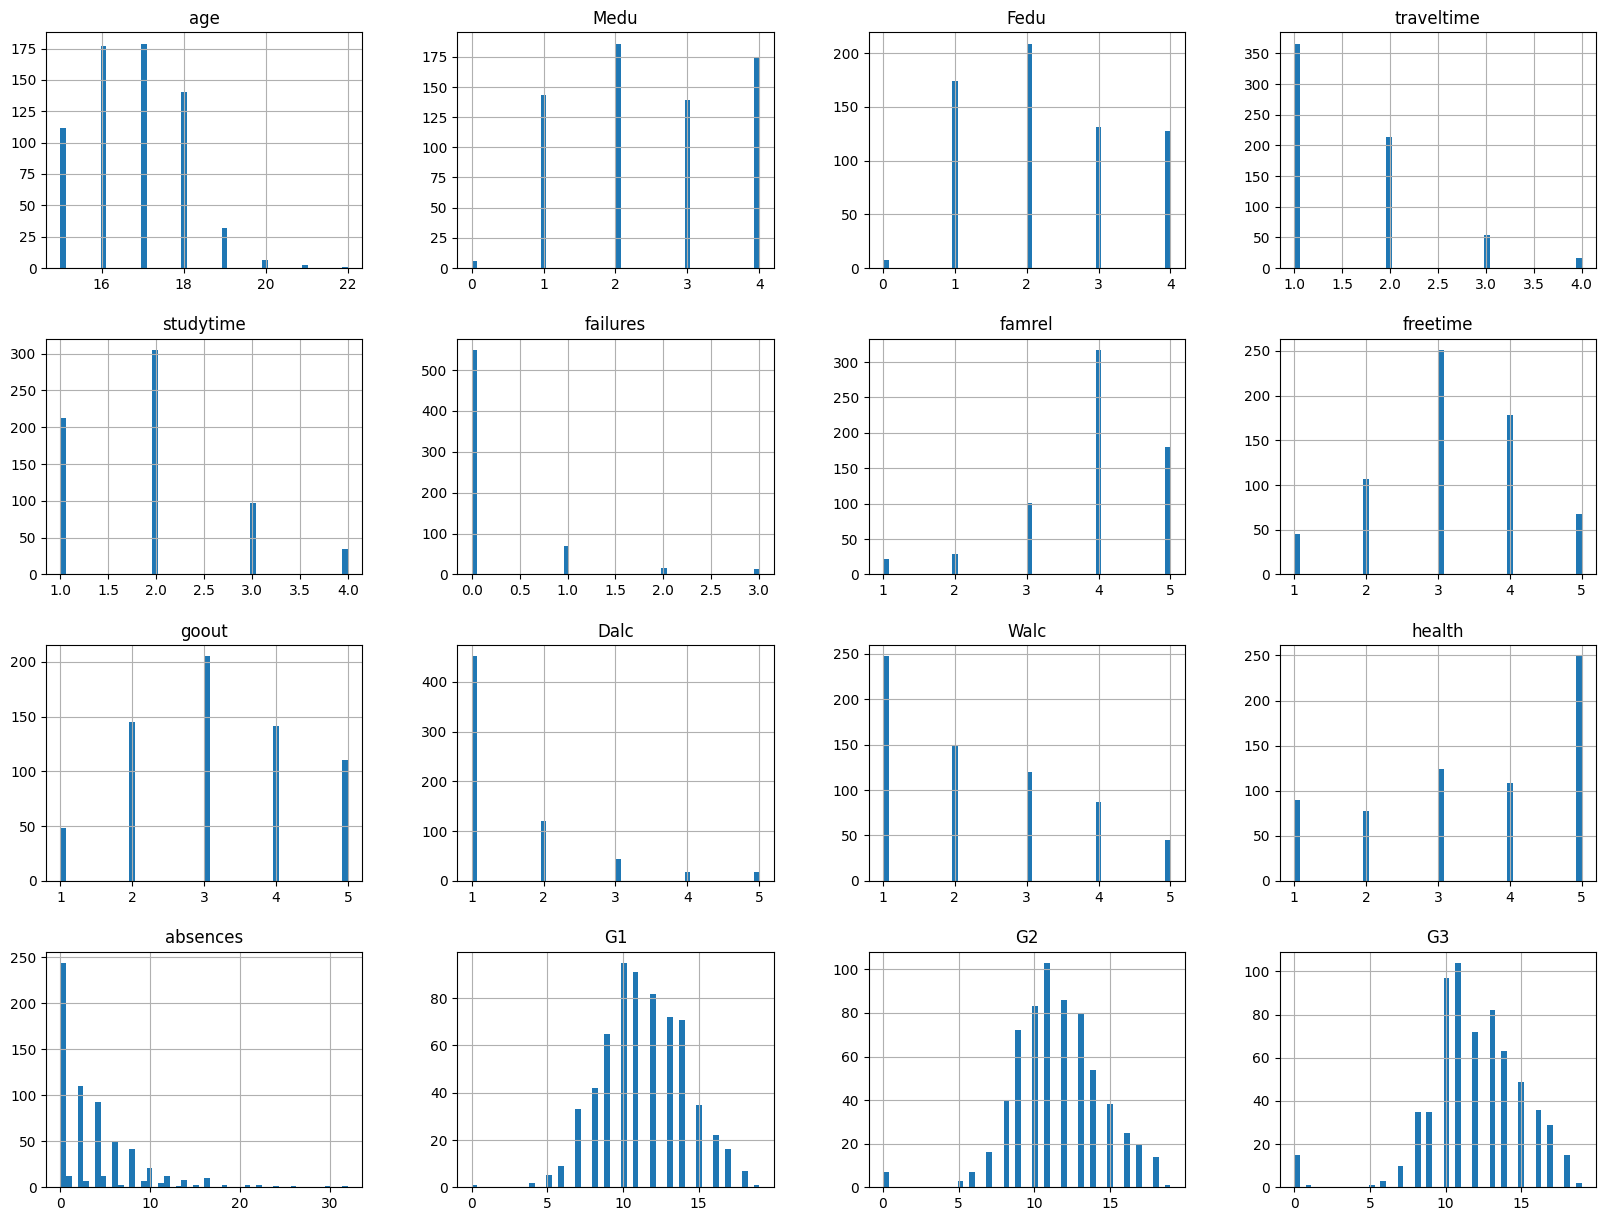

In [6]:
import matplotlib.pyplot as plt
student_performance.hist(bins=50,figsize=(20,15))
plt.show()

Etant donné que nos valeurs numériques sont bornées, on voit assez peu de valeurs aberrantes (outliers). On notera toutefois la quantité significative d'étudiants ayant reçu un 0 alors qu'aucun n'a reçu une note comprise entre 1 et 4. Ce sera itéressant de voir comment notre modèle va gérer ça.

  De plus, il y a quand même une certaine différence d'échelle entre les différentes variables (les valeurs de la catégorie "absences" sont comprises entre 0 et 30, celles de la catégorie "age" de 0 à 22, celles des catégories "G1", "G2" et "G3" de 0 à 20 tandis que les autres sont en gros entre 0 et 5).

  On sera donc probablement amené à devoir normaliser les données.

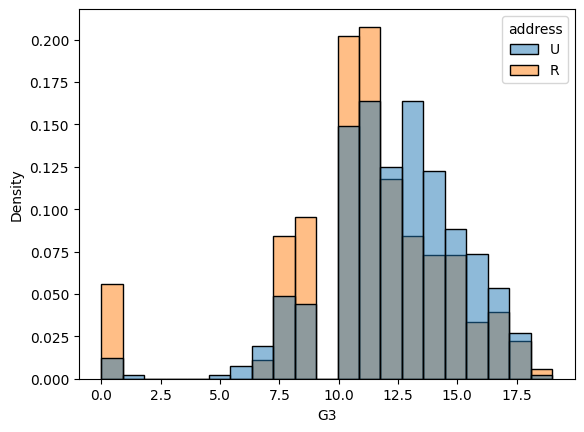

In [7]:
import seaborn as sns
sns.histplot(
    data=student_performance.query("address=='U'or address=='R'"),
    x="G3",
    hue="address",
    stat="density",
    common_norm=False,
);

A première vue, il semble que les élèves qui viennent de zones urbaines ont plus de chance d'avoir une bonne moyenne en portugais au 3ème trimestre que les élèves venant de zones rurales.

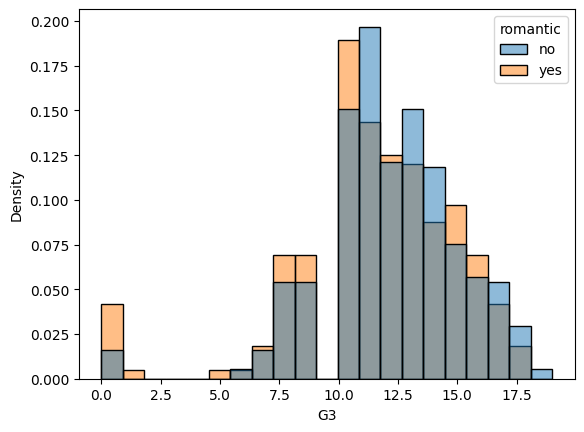

In [8]:
sns.histplot(
    data=student_performance.query("romantic=='yes'or romantic=='no'"),
    x="G3",
    hue="romantic",
    stat="density",
    common_norm=False,
);

On constate que les élèves en échec (moyenne inférieure à 10) ont tendance à être en couple. Pour les notes correctes (entre 11 et 14) il y a une part conséquente d'élèves en couple. Par contre, les bons élèves (plus de 14) ont tendance à être célibataires.

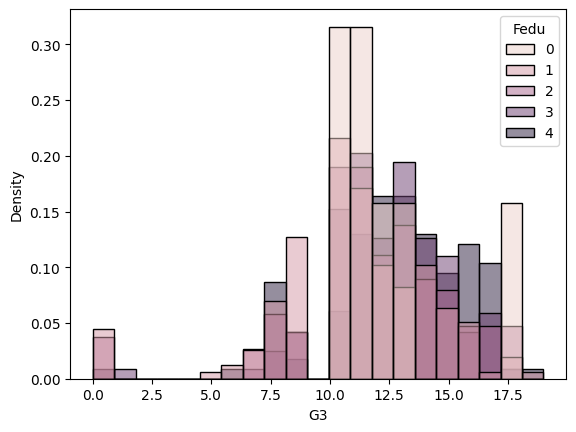

In [9]:
sns.histplot(
    data=student_performance.query("Fedu==0 or Fedu==1 or Fedu==2 or Fedu==3 or Fedu==4"),
    x="G3",
    hue="Fedu",
    stat="density",
    common_norm=False,
);

Ici, il est nettement plus difficile de déceler des tendances (d'où la nécessité de développer un modèle de machine learning et de ne pas se contenter de visualiser les données avec matplotlib et seaborn).

On peut toutefois noter qu'il semble que parmi les étudiants ayant des notes moyennes (entre 8 et 12) et parmi les étudiants ayant de très bonnes notes (plus de de 16,5) il y a beaucoup d'élèves dont le père n'a pas une très bonne situation professionnelle (catégories 1 et 2). De plus, on remarque que parmi les élèves ayant de bonnes notes (entre 12 et 16) il y a une proportion importante d'élèves dont le père a une bonne situation professionnelle (catégories 3 et 4).

Tous ces histogrammes sont riches en enseignement mais on ne va pas "s'amuser" à faire ça pour toutes les variables.

On va maintenant chercher à mettre en évidence les corrélations qui existent entre chacune de nos variables et notre target  G3.
Pour cela, on affiche la matrice de corrélation de chacune de nos variables ainsi que la carte de chaleur (heatmap) de ces dernières :

In [10]:
import pandas as pd
correlation_matrix=student_performance.corr()
print("Matrice de corrélation :\n", correlation_matrix)

Matrice de corrélation :
                  age      Medu      Fedu  traveltime  studytime  failures  \
age         1.000000 -0.107832 -0.121050    0.034490  -0.008415  0.319968   
Medu       -0.107832  1.000000  0.647477   -0.265079   0.097006 -0.172210   
Fedu       -0.121050  0.647477  1.000000   -0.208288   0.050400 -0.165915   
traveltime  0.034490 -0.265079 -0.208288    1.000000  -0.063154  0.097730   
studytime  -0.008415  0.097006  0.050400   -0.063154   1.000000 -0.147441   
failures    0.319968 -0.172210 -0.165915    0.097730  -0.147441  1.000000   
famrel     -0.020559  0.024421  0.020256   -0.009521  -0.004127 -0.062645   
freetime   -0.004910 -0.019686  0.006841    0.000937  -0.068829  0.108995   
goout       0.112805  0.009536  0.027690    0.057454  -0.075442  0.045078   
Dalc        0.134768 -0.007018  0.000061    0.092824  -0.137585  0.105949   
Walc        0.086357 -0.019766  0.038445    0.057007  -0.214925  0.082266   
health     -0.008750  0.004614  0.044910   -0.0482

<ipython-input-10-f59ea6224851>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix=student_performance.corr()


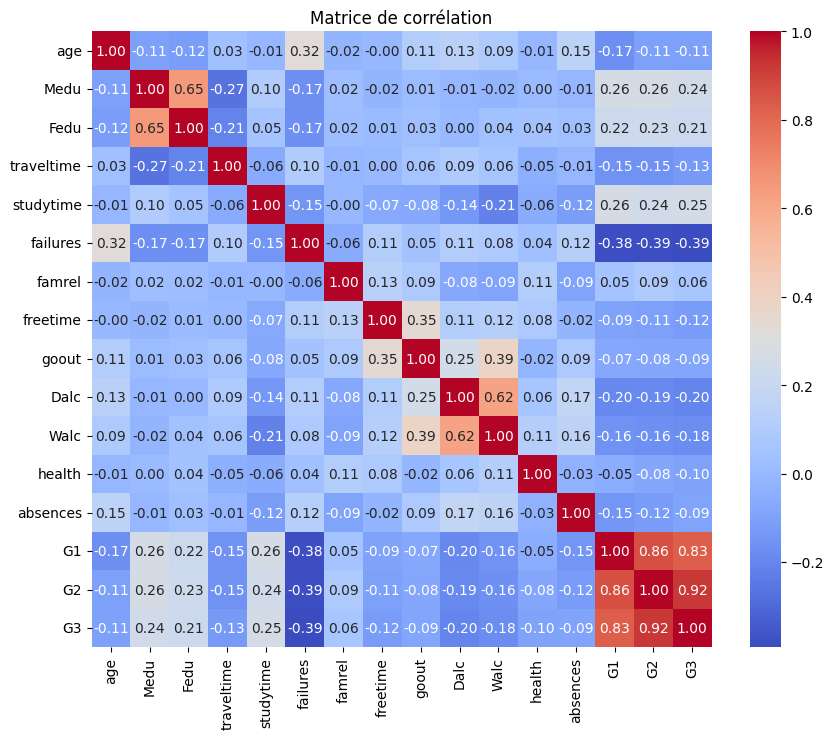

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corrélation')
plt.show()

On remarque que G1, G2 et G3 sont très fortement corrélées (0,86 entre G1 et G2, 0,83 entre G1 et G3 et 0,92 entre G2 et G3). C'est tout à fait logique. En effet, beaucoup d'élèves qui étaient en échec (respectivement en réussite) aux précédents trimestres seront en échec (respectivement en réussite) au dernier trimestre.

Le fait qu'il y ait une telle corrrélation entre G1, G2 et notre target rend notre projet beaucoup moins utile et pertinent. **On choisit donc de supprimer les variables de notre dataset pour ne garder que les variables purement "sociales".**





In [12]:
data=data.drop(columns="G1")
data=data.drop(columns="G2")


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

On remarque également que les variables "Fedu" et "Medu" qui représentent respectivement le niveau d'études du père de l'élève et celui de sa mère sont fortement corrélées  (0,65) ce qui signifie que de manière générale les gens ont tendance à se mettre en couple avec des gens ayant le même capital culturel/scolaire qu'eux. De même, les variables "Dalc" et "Walc" qui représentent respectivement la consommation d'alcool en semaine de l'étudiant et sa consommation d'alcool par week-end sont fortement corrélées (0,62) .

**On peut donc légitimement se demander s'il ne serait pas possible de supprimer une des variables du couple ("Fedu", "Medu") et une des variables du couple ("Walc", "Dalc") puisqu'elles semblent redondantes vis-à-vis de l'autre.**

***IV) Pré-traitement et nettoyage des données***

Cette réflexion introduit parfaitement notre prochaine étape : le nettoyage et le pré-traitement (pre-processing) des données.

On choisit d'abord de séparer notre dataset en un train set (80% du dataset) et un test set (20% du dataset).

In [13]:
X,y=data,target

In [14]:
y.value_counts()

11    104
10     97
13     82
12     72
14     63
15     49
16     36
9      35
8      35
17     29
18     15
0      15
7      10
6       3
19      2
1       1
5       1
Name: G3, dtype: int64

In [15]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

y_test.value_counts()

11    20
10    20
13    13
14    12
9     12
12    10
15     9
16     9
18     7
8      5
17     5
0      4
7      2
19     1
1      1
Name: G3, dtype: int64

On remarque que la proportion des différentes classes de G3 n'est pas exactement la même dans y_test que dans y (par exemple la classe 12 représente 11% des valeurs alors qu'elle ne représente que 7% des
valeurs de y_test).

On pourrait penser que le fait d'imposer **une stratification empêcherait ce genre de souci**. Le problème c'est que lorsque l'on tente de stratifier on reçoit un message d'erreur car certaines de nos classes ne comportent qu'un élément, cette classe sera donc forcément absente soit de y_train soit de y_test.

**Cela illustre une faiblesse intrinsèque de notre dataset : il possède un nombre d'instances (649) un peu faible.**

N'ayant pas le choix, on va continuer le projet sans stratifier le train set et le test set en espérant que cela n'ait pas trop d'impact négatif sur les performances de notre modèle.





On va maintenant normaliser nos données afin de faciliter le travail de notre modèle (cela évite qu'une variable prenne plus d'"importance" que d'autres lors de l'exécution de notre algorithme).
On choisit d'utiliser StandardScaler (plutôt que MinMaxScaler ou RobustScaler par exemple) car c'est un scaler plus adapté au PCA qu'on va réaliser ensuite.

In [55]:
from sklearn.preprocessing import StandardScaler

colonnes_numeriques = data.select_dtypes(include=['number'])
numeric_columns = colonnes_numeriques.columns

colonnes_categorielles=data.select_dtypes(include=['object'])
categorical_columns =colonnes_categorielles.columns

scaler = StandardScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.fit_transform(X_test[numeric_columns])




In [60]:
X_train[numeric_columns]
X_test[numeric_columns]


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences
440,-0.585602,-1.334458,-1.152289,0.348979,-0.056837,-0.327606,1.067684,0.763304,1.631605,2.844734,2.016110,-0.335670,-0.724176
242,1.106137,-0.479879,-1.152289,2.801264,-0.056837,-0.327606,0.069131,-0.190826,-0.976288,2.844734,2.016110,-0.335670,-0.278001
465,1.106137,-1.334458,-0.296303,-0.877163,-0.056837,1.700429,-0.929423,0.763304,0.762307,0.518851,0.474379,1.071979,1.283610
347,0.260268,1.229279,1.415669,0.348979,1.174630,-0.327606,1.067684,-0.190826,0.762307,-0.644091,-1.067352,1.071979,-0.724176
474,-1.431472,-1.334458,0.559683,1.575121,-1.288304,-0.327606,0.069131,-1.144956,0.762307,1.681792,2.016110,-0.335670,-0.278001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,-0.585602,-1.334458,-0.296303,-0.877163,-0.056837,-0.327606,0.069131,0.763304,-0.106991,-0.644091,-1.067352,-1.743319,-0.724176
419,1.952007,-0.479879,-1.152289,-0.877163,-1.288304,-0.327606,1.067684,-0.190826,0.762307,-0.644091,1.245244,0.368154,1.506697
603,1.106137,1.229279,-0.296303,-0.877163,-0.056837,-0.327606,1.067684,-0.190826,-1.845586,-0.644091,-1.067352,1.071979,-0.724176
385,1.106137,-0.479879,-0.296303,2.801264,-0.056837,-0.327606,0.069131,-1.144956,1.631605,-0.644091,-1.067352,-1.039494,-0.278001


Maintenant, on encode les variables catégorielles avec un OneHotEncoder :

In [56]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()





In [40]:
X_train[categorical_columns]
X_test[categorical_columns]

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
440,MS,M,U,GT3,T,at_home,services,home,mother,no,yes,no,yes,yes,yes,no,yes
242,GP,M,U,LE3,T,at_home,other,course,mother,yes,yes,no,yes,yes,yes,yes,yes
465,MS,F,U,GT3,T,other,other,course,father,no,yes,no,yes,yes,yes,yes,yes
347,GP,F,R,GT3,T,services,services,reputation,mother,no,yes,no,yes,yes,yes,yes,no
474,MS,M,R,LE3,T,at_home,other,reputation,father,no,yes,no,yes,yes,yes,yes,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,GP,F,U,LE3,T,other,services,reputation,father,yes,no,no,yes,yes,yes,yes,no
419,GP,M,U,GT3,T,other,other,reputation,mother,no,no,no,no,yes,yes,yes,no
603,MS,F,R,LE3,A,teacher,other,reputation,mother,no,no,no,yes,yes,yes,yes,yes
385,GP,F,U,GT3,T,at_home,other,course,mother,no,no,no,yes,yes,yes,no,yes


Ensuite, on applique le PCA (Décomposition en parties principales) afin de réduire la dimension du dataset (